In [1]:
import argparse
import os
import sys
from datetime import datetime

import numpy as np
import torch
import yaml
from tqdm import tqdm

from vae_60_80 import VAE

def count_parameters(net):
    # return the number of parameters of the model
    return sum(p.numel() for p in net.parameters() if p.requires_grad)


In [2]:
# we want to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used:", device)

device used: cuda


In [3]:
batch_size=64
nb_epochs=100

parameters = {
    "img_channels_vae": 1,
    "latent_dim_vae": 20,
    "beta_vae": 1,
    "learning_rate_vae": 1e-4,
    "batch_size_vae":64,
    "nb_epochs_vae":10
}


In [5]:
# import random rollout data from the Task-Hallway environment
data = np.load("data/randomRollout.npy")
data = data / 255
print(data.shape)

(100000, 60, 80, 1)


In [6]:
train_loader = torch.utils.data.DataLoader(
        dataset=data, batch_size=parameters['batch_size_vae'], shuffle=True
    )

In [7]:
model = VAE(
            img_channels=parameters["img_channels_vae"],
            latent_dim=parameters["latent_dim_vae"],
            beta=parameters["beta_vae"],
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=parameters["learning_rate_vae"])
print("number of parameters :", count_parameters(model))


number of parameters : 1963625


In [13]:

for epoch in range(nb_epochs):
    pbar = tqdm(train_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch + 1))

    for x in pbar:
        imgs = x
        imgs = imgs.to(device).float()
        imgs = imgs.unsqueeze(1).squeeze(-1)
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logsigma = model(imgs)

        # print(out.shape,imgs.shape,mu.shape,logsigma.shape)
        loss, loss_KL = model.loss_function(out, imgs, mu, logsigma)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(
            "epoch "
            + str(epoch + 1)
            + "/"
            + str(nb_epochs)
            + " loss= "
            + str(loss.cpu().detach().numpy())
            + " loss KL = "
            + str(loss_KL.cpu().detach().numpy())
        )


epoch 10/100 loss= 61632.855 loss KL = 904.9866: 100%|██████████| 1563/1563 [01:46<00:00, 14.69it/s]  
epoch 11/100 loss= 118908.836 loss KL = 1776.7045:  28%|██▊       | 444/1563 [00:30<01:15, 14.73it/s]


KeyboardInterrupt: 

In [14]:
# save model
torch.save(model.state_dict(), "saved_models/vae_z20_06042023.pt")

In [9]:
# load model
model.load_state_dict(torch.load("saved_models/vae_z20_06042023.pt"))

<All keys matched successfully>

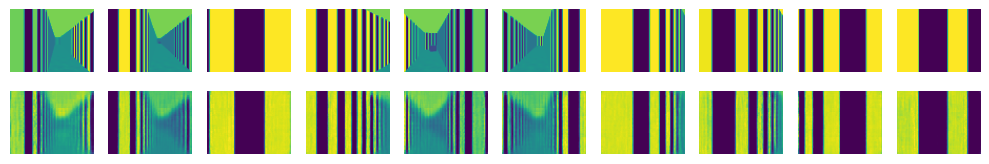

In [10]:
import random
import matplotlib.pyplot as plt

def plot_video_comparison(video, reconstructed_video):
    nb_frame = video.shape[0]
    fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    fig.tight_layout()

imgs = np.array(random.sample(list(data), 10))
imgs_tensor = torch.tensor(imgs).to(device).float().unsqueeze(1).squeeze(-1)
out_tensor, mu, logsigma = model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()

plot_video_comparison(imgs.squeeze(-1),out.squeeze(1))

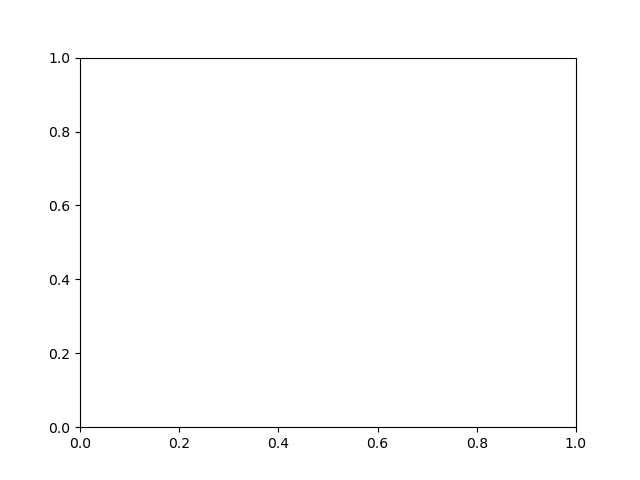

In [11]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def plot_latent(**kwargs):
    """
    Print the current widget value in short sentence
    """
    z = []
    for z_i in locals()['kwargs']:
        z.append(locals()['kwargs'][z_i])
    z = torch.tensor(z).unsqueeze(0).float().to(device)
    out = model.decoder_pass(z)
    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
    ax.imshow(np.squeeze(outimg))
    ax.set_axis_off()
    fig.canvas.draw()
    
latent_dim = mu.shape[1]
latent_variables_init = {}
for i in range(latent_dim):
    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()
w = widgets.interactive(plot_latent,**latent_variables_init)
for slider in w.children:
    slider.min = -4
    slider.max = 4
    slider.orientation='vertical'
    slider.layout = Layout(width='90%')

display(HBox(w.children))